# SEIR Generalize model with rho as a polynomial spline
#Author: Imelda Trejo 
#February 13, 2022

MCMC: YT

In [208]:
# Import relevant modules
import numpy as np
import pandas as pd
import random
from scipy.stats import nbinom, expon
from scipy.special import factorial
from scipy.special import loggamma
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from copy import copy
from matplotlib import cm
import time

In [209]:
#---------Polynomial spline
def Pspline(t,vk,c,k,q0):
    n = len(vk) - k
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * BaseSpline(t, k, i, vk,q0) for i in range(n))   
#---------mixing-monotonic-and-standar-Base
def BaseSpline(t,k,i,T,q0): #k0,,t0=6--->90
    n = len(t)
    b=np.zeros(n) ##base function of degree k-1
    if i<=q0:
        aux=BSpline.basis_element(T[i+1:i+k+1],extrapolate=False) #degree k-2
        a=aux.integrate(T[i+1],T[i+k+1])
        for j in range(0,tp):                                 #M-spline degree k-1
            b[j]=1-aux.integrate(T[1],t[j])/a
    else:
        b= BSpline.basis_element(vk[i:i+k+1],extrapolate=False)(t) #degree k-1
    return np.nan_to_num(b)

In [210]:
##------------------------Read data------------
#Yaux=np.load("New MexicoY.npy")  #Incidence data
#Yaux=np.load("TexasY.npy")  #Incidence data
Yaux=np.load("CaliforniaY.npy")  #Incidence data

#Yaux=np.load("LinY.npy") 

n=np.size(Yaux)
print('observation days',n)
#----------------------Average data per 7 days-------------
Y=np.zeros(n) 
for k in range(3,n):
    Y[k]=np.mean(Yaux[k-3:k+4]) 
Y[0]=np.mean(Yaux[0:7])
Y[1],Y[2]=Y[0],Y[0]
#-----------------------Define the partition for the epidecmis time observed [0, T]  
T,h,m=n,0.1,10
tp=int(T/h)+1            #total points
t=np.zeros(tp)
for i in range(0,tp):
    t[i]=h*i  
#--------------------Infectious period functions-----------------
##laten distribution
Faux=np.load("F.npy")
Gaux=np.load("Gaux.npy") #1-G(t)
Psi=np.load("Psi.npy")
Aaux=np.load("A.npy")
Waux=np.load("W.npy")

F=Faux[0:tp]   #Lauer20
G=Gaux[0:tp]   #Lauer20
psi=Psi[0:tp]  #Lauer #Ferr G3
A=Aaux[0:n,:]
W=Waux[0:tp]

#print(tp)
#print(t[-2:])
#plt.plot(psi[0:200])

observation days 754


In [211]:
#---------------------------Epidemic Global Variables---------------------------
#---------------Initial values:SEIR    
I0,E0,R0=100,0,0        

#---History-function---H----
H=np.zeros((n,m+1))
for i in range(0,m+1):
    H[0,i]=G[i]*I0
for k in range(1,n):
    for i in range(0,m+1):
            H[k,i]=np.dot(Y[0:k],np.flip(A[0:k,i]))+G[k*m+i]*I0    
    

In [212]:
#------------------------Base-spline interpolation----with partition (0,T)={0,xhi_1,...,xhi_q,T}
ls=21                    #length between the k-nots 
q=int(n/ls)+1         
vk=np.zeros(q)
for i in range(1,q-1):
    vk[i]=ls*i
vk[q-1]=n
#-------------------------------boundary-knots
vk=np.append([-3*ls,-2*ls,-ls],vk)
vk=np.append(vk,[n+ls,n+2*ls,n+3*ls])
#--------------Wigths
q=q+2  #base elements
print('Dimention of the Base-spline',q)    
#-------------------Bsplines functions: derivatives and gram matrix
q0=8                  #number of monotonic base functions


Dimention of the Base-spline 38


In [213]:
#---Muk----ls days constant period----estimation with 1-intergal
def MuK(par): 
    mu,rho,V,hatI=np.zeros(n+1),np.ones(tp),np.zeros(tp),np.zeros(m+1)
    mu[0]=I0
    rho=np.exp(Pspline(t,vk,par,4,q0)) 
    V[0]=rho[0]*H[0,0]
    for k in range(1,n+1):
        for i in range(0,m+1):
            v=np.multiply(rho[m*(k-1):m*(k-1)+i],hatI[0:i])
            hatI[i]=h*(rho[m*(k-1)]*hatI[0]*psi[i]+2*np.dot(v[1:i],np.flip(psi[1:i])))/2+H[k-1,i] #hatI
        V[m*(k-1)+1:k*m+1]=np.multiply(rho[m*(k-1)+1:m*k+1],hatI[1:m+1]) #open-left
        mu[k]=h*(V[0]*W[k*m]+2*np.dot(V[1:m*k],np.flip(W[1:m*k]))+V[m*k]*W[0])/2    
    return mu

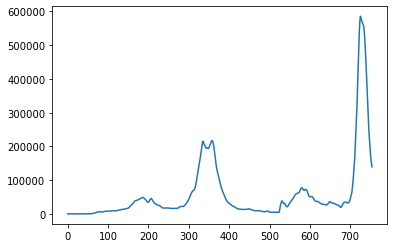

In [214]:
hI=np.zeros(tp)
AuxI=psi*E0+G*I0
for k in range(1,n+1):
    for i in range(1,m+1):
        sum1=0
        for j in range(1,k):
            sum1=sum1+(G[(k-j)*m+i]+G[(k-j-1)*m+i]+2*np.sum(G[(k-j-1)*m+i+1:(k-j)*m+i]))*Y[j-1]/(2*m)
        hI[(k-1)*m+i]=sum1+Y[k-1]*(1+G[i]+2*np.sum(G[1:i]))/(2*m) 
hI=hI+AuxI
plt.plot(t,hI)    

#----matrix auxiliar
B=np.zeros((m+1,m*(n-1)-1))
for k in range(2,n+1):
    for i in range(0,m+1): 
        B[i,0:m*(k-1)-1]=np.flip(psi[i+1:m*(k-1)+i])  


In [215]:
def MuKOLD(par): 
    mu,Q,P=np.zeros(n+1),np.ones(tp),np.zeros(tp)
    mu[0],P[0],a=hI[0],AuxI[0],np.zeros(m+1)
    Q=np.exp(Pspline(t,vk,par,4,q0))
    for i in range(1,m+1):
        v=np.multiply(Q[1:i],P[1:i]) #element wise
        P[i]=h*(Q[0]*P[0]*psi[i]+2*np.dot(v,np.flip(psi[1:i])))/2
    mu[1]=h*(Q[0]*P[0]*W[m]+2*np.dot(v,np.flip(W[1:m])))/2
    for k in range(2,n+1):
        hv=np.multiply(Q[1:m*(k-1)],hI[1:m*(k-1)])
        a=h*(np.dot(B[:,0:m*(k-1)-1],hv))+h*(Q[0]*hI[0]*psi[m*(k-1):m*k+1]+Q[m*(k-1)]*hI[m*(k-1)]*psi[0:m+1])/2
        P[m*(k-1)]=AuxI[m*(k-1)]+a[0]
        for i in range(1,m+1):
            v=np.multiply(Q[m*(k-1)+1:m*(k-1)+i],P[m*(k-1)+1:m*(k-1)+i])
            P[m*(k-1)+i]=h*(Q[m*(k-1)]*P[m*(k-1)]*psi[i]+2*np.dot(v,np.flip(psi[1:i])))/2+a[i]
            if i==m: 
                mu[k]=h*(Q[m*(k-1)]*P[m*(k-1)]*W[m]+2*np.dot(v,np.flip(W[1:m])))/2+h*(Q[0]*hI[0]*W[k*m]+2*np.dot(hv,np.flip(W[m+1:m*k]))+Q[m*(k-1)]*hI[m*(k-1)]*W[m])/2 
    return mu


In [216]:
#iniPar =-1*np.random.rand(q+2)
iniPar=-.5*np.ones(q+2)

In [217]:
timep=time.perf_counter()
mukAux=MuK(iniPar)
elapsed_time = time.perf_counter() - timep
print(elapsed_time)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


0.22570388199892477
00:00:00


In [218]:
#Faster
timep=time.perf_counter()
#muk=MuK(iniPar)
elapsed_time = time.perf_counter() - timep
print(elapsed_time)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


4.688199987867847e-05
00:00:00


In [219]:
timep=time.perf_counter()
mukOLD=MuKOLD(iniPar)
elapsed_time = time.perf_counter() - timep
print(elapsed_time)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


0.2897530580012244
00:00:00


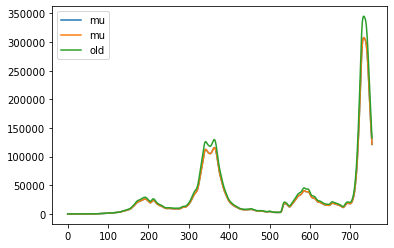

In [220]:
#plt.plot(Y,label='Y')
plt.plot(muk,label='mu')
plt.plot(mukAux,label='mu')
plt.plot(mukOLD,label='old')

plt.legend()


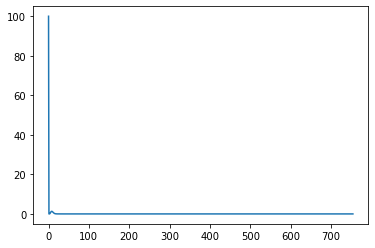

In [222]:
plt.plot(mukAux-muk,label='mu')
